<a href="https://colab.research.google.com/github/Noha-Magdy/AI-Programming-Nanodegree-from-Udacity-Quizes-and-Labs-/blob/master/Regression_effecientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
import itertools
 
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data pipeline

In [3]:
train_src = "/content/gdrive/MyDrive/AIRABreast/AI Experiments/Tissue/Combined_classification_and_regression/Dataset/data/train"
val_src = "/content/gdrive/MyDrive/AIRABreast/AI Experiments/Tissue/Combined_classification_and_regression/Dataset/data/val"
labels = pd.read_csv("/content/gdrive/MyDrive/AIRABreast/AI Experiments/Tissue/Combined_classification_and_regression/Dataset/kasr_tissue_percentage.csv")


# train_src = "/content/gdrive/MyDrive/Combined_classification_and_regression/Dataset/data/train"
# val_src = "/content/gdrive/MyDrive/Combined_classification_and_regression/Dataset/data/val"
# labels = pd.read_csv("/content/gdrive/MyDrive/Combined_classification_and_regression/Dataset/kasr_tissue_percentage.csv")


# labels = labels[labels.Tissue != "-1"]
size = (512, 512)

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,2)),
])

In [33]:
@tf.function
def square(x):
  shape = tf.shape(x)
  h, w, c = shape[0], shape[1], shape[2]
 
  if h>w:
    pad = h-w
    first_pad = tf.cast(tf.math.ceil((h-w)/2), tf.int32)
    second_pad = tf.cast(tf.math.floor((h-w)/2), tf.int32)
 
    paddings = tf.concat(([[0, 0]],
                                [[first_pad, second_pad]],
                                [[0, 0]]), axis=0)
 
    x = tf.pad(x, paddings, "CONSTANT")
 
 
  elif w>h:
    pad = h-w
    first_pad = tf.cast(tf.math.ceil((w-h)/2), tf.int32)
    second_pad = tf.cast(tf.math.floor((w-h)/2), tf.int32)
 
    paddings = tf.concat(([[first_pad, second_pad]],
                                [[0, 0]],
                                [[0, 0]]), axis=0)
 
    x = tf.pad(x, paddings, "CONSTANT")
 
  return x
 
def load_y(csv, y):
  return csv[csv["Case Number"]==y]["Tissue"]
 
def load(src, size, x, y):
  x1 = x
  # tf.print(x)
  x = tf.strings.join((src, "/", x))
  x = tf.io.read_file(x)
  x = tf.io.decode_png(x)
  x = square(x)
  x = tf.cast(x[:,:,:3], tf.float32)/255.  
  x = tf.image.resize(x, size)
  x = tf.squeeze(x)
  x = tf.stack([x, x, x], axis=-1)
 
  return (x, y)
 
def load_split(src, size, csv, buffer_size=100, batch=8, augment = False ):
  train_names = sorted(os.listdir(src))
  

  train_names = [ i for i in train_names if csv[csv["Case Number"] == i.split("_")[0]]["Tissue Percentage"].values[0]!=-1]
  print(len(train_names))
  target = [csv[csv["Case Number"] == i.split("_")[0]]["Tissue Percentage"].values[0] for i in train_names if csv[csv["Case Number"] == i.split("_")[0]]["Tissue Percentage"].values[0]!=-1]
  target = [i/100 for i in target]
  target = tf.cast(target, tf.float32)
 
  dataset = tf.data.Dataset.from_tensor_slices((train_names, target))
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.map(lambda x, y: load(src, size, x, y)) 
  dataset = dataset.batch(batch)
 
  # dataset = dataset.cache()
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
 
  return dataset
 
 
 
# for i in load_split(val_src, size, labels).take(1): print((i))

In [34]:
 
train = load_split(train_src, size, labels)
val = load_split(val_src, size, labels)

2093
663


## Model

In [ ]:
# base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights='imagenet')
 
# base_model.trainable = True
# # for layer in base_model.layers:
# #     layer.trainable = False
 
# # for layer in base_model.layers[-20:]:
# #     layer.trainable = True
# top_dropout_rate = 0.2
 
# model = tf.keras.Sequential([
#           tf.keras.layers.InputLayer((512, 512, 3)),
#           tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#           tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,2)),
#           base_model,
  
 
#           tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
#           tf.keras.layers.BatchNormalization(),
#           tf.keras.layers.Dense(500),
#           tf.keras.layers.Dropout(top_dropout_rate),
#           tf.keras.layers.Dense(50),

#           tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout"),
#           tf.keras.layers.Dense(1, activation="sigmoid", name="pred")
# ])
 
# model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, None, None, 1280)  6575239   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_10 (Dense)             (None, 500)               640500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                25050     
_________________________________________________________________
top_dropout (Dropout)        (None, 50)               

In [41]:
!pip install efficientnet
import efficientnet.tfkeras as efn 
base_model = efn.EfficientNetB1(include_top=False, weights='imagenet')
 
base_model.trainable = True

 
model = tf.keras.Sequential([
          tf.keras.layers.InputLayer((512, 512, 3)),
          # tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
          base_model,
          
          tf.keras.layers.Conv2D(512, kernel_size = 3, padding = 'same', activation='relu',kernel_initializer='he_normal'),
          # tf.keras.layers.Conv2D(, kernel_size = 3),

          tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.Dense(200),
          # tf.keras.layers.Dropout(0.3),
          # tf.keras.layers.Dense(20),

          # tf.keras.layers.Dropout(0.3, name="top_dropout"),
          tf.keras.layers.Dense(1, activation="sigmoid", name="pred")
])
 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Functional) (None, None, None, 1280)  6575232   
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 512)       5898752   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
pred (Dense)                 (None, 1)                 513       
Total params: 12,476,545
Trainable params: 12,413,473
Non-trainable params: 63,072
_________________________________________________________________


In [27]:
# path = "/content/gdrive/MyDrive/AIRABreast/AI Experiments/Tissue/Combined_classification_and_regression/weights"+"/expriment_"+str(53)
# os.mkdir(path)

In [43]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
model.compile(optimizer=optimizer, loss="mse")

In [44]:
class SaveBestLoss(tf.keras.callbacks.Callback):
    def __init__(self,path, metric='val_loss', best = 10000, **kwargs):
        super().__init__(**kwargs)
        self.metric = metric
        self.best = best
        self.path = path

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.metric]
        if metric_value < self.best:
          self.best = metric_value
          self.best_weights= self.model.get_weights()
          self.model.save_weights(self.path+"/best_loss.h5")


In [45]:
class ModelSave(tf.keras.callbacks.Callback):
    """
    Model save every n epoch
    """
    def __init__(self, n_epoch, path, **kwargs):
        super().__init__(**kwargs)
        self.n_epoch = n_epoch
        self.path = path

    def on_epoch_end(self, epoch, logs=None):
        path=self.path
        if epoch % self.n_epoch == 0:
            self.model.save_weights(path+"/_"+str(epoch)+".h5")

In [46]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=0.0000001)
 
early_stoppng = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001, restore_best_weights=True)

save_best_loss= SaveBestLoss(path = "/content/gdrive/MyDrive/AIRABreast/AI Experiments/Tissue/Combined_classification_and_regression/weights/expriment_"+str(53))
save = ModelSave(n_epoch=1, path= "/content/gdrive/MyDrive/AIRABreast/AI Experiments/Tissue/Combined_classification_and_regression/weights/expriment_"+str(53))

In [ ]:
epochs = 100
history= model.fit(
    train,
    validation_data=val,
    epochs=epochs,
    callbacks=[reduce_lr, early_stoppng, save_best_loss, save]
) 

Epoch 1/100
262/262 [==============================] - 641s 2s/step - loss: 0.0967 - val_loss: 0.0655
Epoch 2/100
262/262 [==============================] - 632s 2s/step - loss: 0.0474 - val_loss: 0.0633
Epoch 3/100
262/262 [==============================] - 627s 2s/step - loss: 0.0339 - val_loss: 0.0480
Epoch 4/100
262/262 [==============================] - 629s 2s/step - loss: 0.0296 - val_loss: 0.0263
Epoch 5/100
262/262 [==============================] - 658s 3s/step - loss: 0.0278 - val_loss: 0.0294
Epoch 6/100
262/262 [==============================] - 640s 2s/step - loss: 0.0234 - val_loss: 0.0518
Epoch 7/100
262/262 [==============================] - 642s 2s/step - loss: 0.0270 - val_loss: 0.0192
Epoch 8/100
262/262 [==============================] - 636s 2s/step - loss: 0.0265 - val_loss: 0.0187
Epoch 9/100
262/262 [==============================] - 640s 2s/step - loss: 0.0257 - val_loss: 0.0188
Epoch 10/100
262/262 [==============================] - 642s 2s/step - loss: 0.022

In [ ]:
model.save_weights("/content/gdrive/MyDrive/Combined_classification_and_regression/weights/effecient_exp_53_w.h5")
model.save("/content/gdrive/MyDrive/Combined_classification_and_regression/weights/effecient_exp_53.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Evaluation

In [ ]:
train_results = model.evaluate(train)
print("train loss, train acc:", train_results)

127/127 [==============================] - 15s 116ms/step - loss: 0.5944
train loss, train acc: 0.5943822860717773


In [ ]:
def to_types(labels):
  new_labels = []
  for i in labels:
    if i < 0.21:
      new_labels.append(0)
    elif i < 0.51:
      new_labels.append(1)
    elif i < 0.80:
      new_labels.append(2)
    else:
      new_labels.append(3)
  return new_labels

l = [0.20, 0.80, 0.46, 0.65, 0.35, 0.99, 0.2]
ll = to_types(l)
ll

[0, 3, 1, 2, 1, 3, 0]

In [ ]:
total_matrix = np.zeros((4,4))
for x, y in train:
  y = to_types(y)
  y_hat = model.predict(x)
  y_hat = to_types(y_hat)
  matrix =  confusion_matrix(y, y_hat, labels=[0,1,2,3])
  total_matrix += matrix 

total_matrix


array([[312.,   0.,   1.,  97.],
       [392.,   1.,   3., 336.],
       [230.,   2.,   1., 486.],
       [ 43.,   0.,   0., 189.]])

In [ ]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

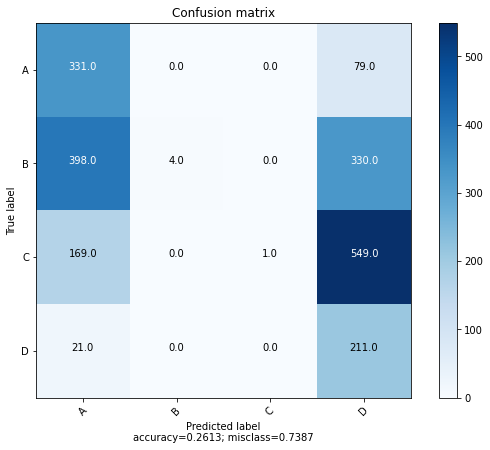

In [ ]:
plot_confusion_matrix(total_matrix, ["A", "B", "C", "D"])